# Dataset  - 4,000 pictures of cats and dogs (2,000 cats, 2,000 dogs). 

## We’ll use 2,000 pictures for training—1,000 for validation, and 1,000 for testing.

### 1. Start by naively training a small convnet on the 2,000 training samples, without any regularization, to set a baseline for what can be achieved. This will get you to a classification accuracy of 71%. 

### 2. At that point, the main issue will be overfitting. Then we’ll introduce data augmentation, a powerful technique for mitigating overfitting in computer vision. By using data augmentation, you’ll improve the network to reach an accuracy of 82%.

### 3. In the next section, we’ll review two more essential techniques for applying deep learning to small datasets: feature extraction with a pretrained network (which will get you to an accuracy of 90% to 96%) and fine-tuning a pretrained network (this will get you to a final accuracy of 97%).

## --------------------------------------------------

### Create directories for train, validation and test sets for both the classes

In [3]:
import os, shutil
original_dataset_dir = './dogs-vs-cats/train'
base_dir = './dogs-vs-cats_small'

os.mkdir(base_dir)
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)


train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)


train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)




### copy images into specific folders

In [4]:
# copies first 1000 cats images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)


In [5]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

('total training cat images:', 1000)
('total training dog images:', 1000)
('total validation cat images:', 500)
('total validation dog images:', 500)
('total test cat images:', 500)
('total test dog images:', 500)


## So you do indeed have 2,000 training images, 1,000 validation images, and 1,000 test images. Each split contains the same number of samples from each class: this is a balanced binary-classification problem, which means classification accuracy will be an appropriate measure of success.

### Create a simple convolution model with a dense layer at the end

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
____

In [8]:
from tensorflow.keras import optimizers
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Data Preprocessing steps

1. Read the picture files.
2. Decode the JPEG content to RGB grids of pixels.
3. Convert these into floating-point tensors.
4. Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

In [9]:
# using imageDataGenerator to read images from directories

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')


validation_generator = test_datagen.flow_from_directory(
validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
# Let's see the output of these generators 
# 150 X 150 RGB images (20, 150, 150 ,3) and binary labels (20,)

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

('data batch shape:', (20, 150, 150, 3))
('labels batch shape:', (20,))


In [11]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 93s 928ms/step - loss: 0.6887 - acc: 0.5345 - val_loss: 0.6979 - val_acc: 0.5060
Epoch 2/30
100/100 [==============================] - 86s 864ms/step - loss: 0.6557 - acc: 0.6195 - val_loss: 0.6419 - val_acc: 0.6360
Epoch 3/30
100/100 [==============================] - 89s 893ms/step - loss: 0.6101 - acc: 0.6680 - val_loss: 0.6127 - val_acc: 0.6570
Epoch 4/30
100/100 [==============================] - 98s 982ms/step - loss: 0.5649 - acc: 0.7080 - val_loss: 0.5908 - val_acc: 0.6800
Epoch 5/30
100/100 [==============================] - 89s 889ms/step - loss: 0.5312 - acc: 0.7290 - val_loss: 0.6267 - val_acc: 0.6540
Epoch 6/30
100/100 [==============================] - 81s 809ms/step - loss: 0.5020 - acc: 0.7575 - val_loss: 0.5992 - val_acc: 0.6810
Epoch 7/30
100/100 [==============================] - 83s 830ms/step - loss: 0.4813 - acc: 0.7650 - val_loss: 0.5611 - val_acc: 0.7080
Epoch 8/30
100/100 [==============================] - 8

## Because the data is being generated endlessly, the Keras model needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the steps_per_epoch argument: after having drawn steps_per_epoch batches from the generator—that is, after having run for steps_per_epoch gradient descent steps—the fitting process will go to the next epoch. In this case, batches are 20 samples, so it will take 100 batches until you see your target of 2,000 samples.


## If you pass a generator as validation_data , then this generator is expected to yield batches of validation data endlessly; thus you should also specify the validation_steps argument, which tells the process how many batches to draw from the validation generator for  valuation.


In [12]:
# save your model
model.save('cats_and_dogs_small_1.h5')

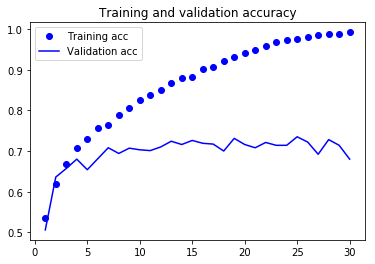

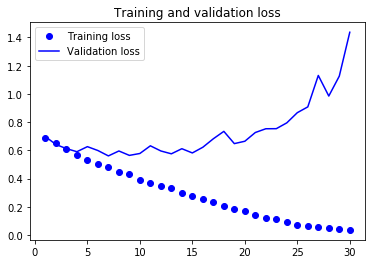

In [14]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## These plots are characteristic of overfitting. The training accuracy increases linearly over time, until it reaches nearly 100%, whereas the validation accuracy stalls at 70–72%.

## The validation loss reaches its minimum after only five epochs and then stalls, whereas the training loss keeps decreasing linearly until it reaches nearly 0.


## Because you have relatively few training samples (2,000), overfitting will be your number-one concern. You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We’re now going to work with a new one, specific to computer vision and used almost universally when processing images with deep-learning models: data augmentation.

## Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data.

## Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In [17]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

1. rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
2. width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
3. shear_range is for randomly applying shearing transformations.
4. zoom_range is for randomly zooming inside pictures. horizontal_flip is for randomly flipping half the images horizontally— relevant when there are no assumptions of horizontal asymmetry (for example,real-world pictures).
5. fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

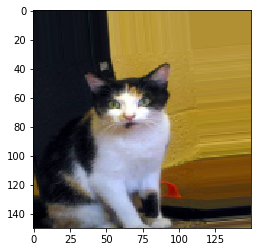

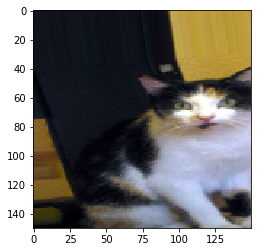

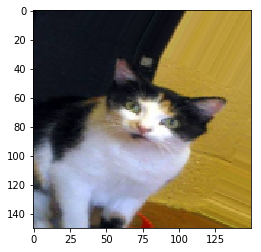

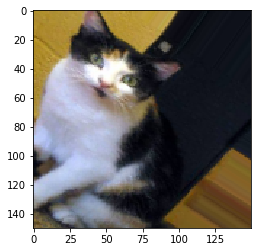

In [19]:
# Let's see some randomly augmented training images

from tensorflow.keras.preprocessing import image
fnames = [os.path.join(train_cats_dir, fname) for
fname in os.listdir(train_cats_dir)]

img_path = fnames[3]
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
        
plt.show()

## To further fight overfitting, you’ll also add a Dropout layer to your model, right before the densely connected classifier.

In [20]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
        optimizer=optimizers.RMSprop(lr=1e-4),
        metrics=['acc'])

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 154s 2s/step - loss: 0.6903 - acc: 0.5306 - val_loss: 0.6769 - val_acc: 0.5952
Epoch 2/100
100/100 [==============================] - 148s 1s/step - loss: 0.6767 - acc: 0.5650 - val_loss: 0.6580 - val_acc: 0.6034
Epoch 3/100
100/100 [==============================] - 154s 2s/step - loss: 0.6687 - acc: 0.6011 - val_loss: 0.6641 - val_acc: 0.5819
Epoch 4/100
100/100 [==============================] - 161s 2s/step - loss: 0.6593 - acc: 0.6114 - val_loss: 0.6340 - val_acc: 0.6428
Epoch 5/100
100/100 [==============================] - 157s 2s/step - loss: 0.6367 - acc: 0.6360 - val_loss: 0.7870 - val_acc: 0.5489
Epoch 6/100
100/100 [==============================] - 173s 2s/step - loss: 0.6304 - acc: 0.6471 - val_loss: 0.5832 - val_acc: 0.6967
Epoch 7/100
100/100 [==============================] - 151s 2s/step - loss: 0.6082 - acc: 0.6705 - val_loss: 0.6

In [22]:
model.save('cats_and_dogs_small_2.h5')

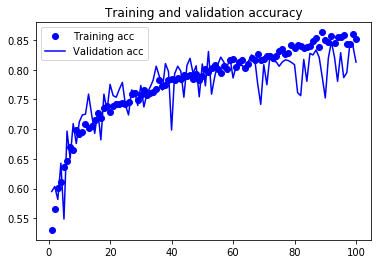

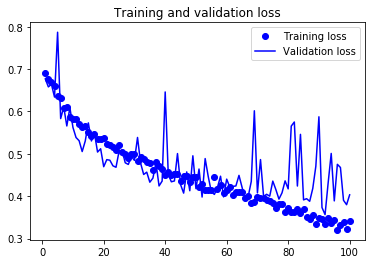

In [23]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


## Thanks to data augmentation and dropout, you’re no longer overfitting: the training curves are closely tracking the validation curves. You now reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

# Using pretrained convnet 


### You’ll use the VGG16 architecture (trained on ImageNet)  

### There are two ways to use a pretrained network: feature extraction and fine-tuning.

# Feature extraction 

#### Let’s put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from cat and dog images, and then train a dogs-versus-cats classifier on top of these features.

In [1]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


1. weights specifies the weight checkpoint from which to initialize the model.
1. include_top refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because you intend to use your own densely connected classifier (with only two classes: cat and dog ), you don’t need to include it.
3. input_shape is the shape of the image tensors that you’ll feed to the network. This argument is purely optional: if you don’t pass it, the network will be able to process inputs of any size.

In [25]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# ways to proceed:

1. Running the convolutional base over your dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier similar to those you saw in part 1 of this book. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow you to use data augmentation.

2. Extending the model you have ( conv_base ) by adding Dense layers on top, and running the whole thing end to end on the input data. This will allow you to use data augmentation, because every input image goes through the convolutional base every time it’s seen by the model. But for the same reason, this technique is far more expensive than the first.

In [27]:
# first approach

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './dogs-vs-cats_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape (samples, 4, 4, 512) . You’ll feed them to a densely connected classifier, so first you must flatten them to (samples, 8192)

In [28]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [30]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
        loss='binary_crossentropy',
        metrics=['acc'])
history = model.fit(train_features, train_labels,
        epochs=30,
        batch_size=20,
        validation_data=(validation_features, validation_labels))
    

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.6035 - acc: 0.6615 - val_loss: 0.4489 - val_acc: 0.8400
Epoch 2/30
2000/2000 [==============================] - 3s 1ms/sample - loss: 0.4274 - acc: 0.8135 - val_loss: 0.3720 - val_acc: 0.8590
Epoch 3/30
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.3560 - acc: 0.8545 - val_loss: 0.3406 - val_acc: 0.8540
Epoch 4/30
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.3142 - acc: 0.8760 - val_loss: 0.2990 - val_acc: 0.8940
Epoch 5/30
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.2835 - acc: 0.8840 - val_loss: 0.2861 - val_acc: 0.8780
Epoch 6/30
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.2705 - acc: 0.8870 - val_loss: 0.2886 - val_acc: 0.8700
Epoch 7/30
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.2479 - acc: 0.9005 - val_loss: 0.2663 - val_acc: 0.9010


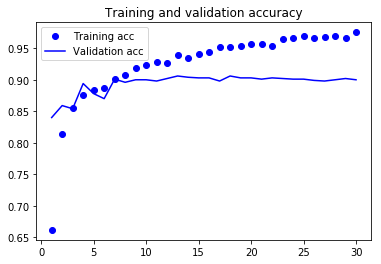

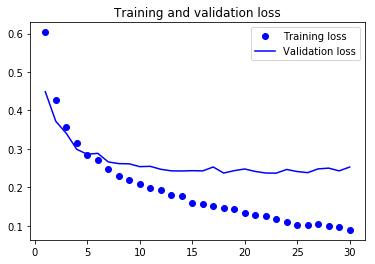

In [31]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

You reach a validation accuracy of about 90%—much better than you achieved in the
previous section with the small model trained from scratch. But the plots also indicate
that you’re overfitting almost from the start—despite using dropout with a fairly large
rate. That’s because this technique doesn’t use data augmentation, which is essential
for preventing overfitting with small image datasets.

In [2]:
# second approach

from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [7]:
# before freezing the conv_base 

print(len(model.trainable_weights))

# after freezing
conv_base.trainable = False
print(len(model.trainable_weights))


30
4


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)



# Let’s plot the results again (see figures 5.17 and 5.18). As you can see, you reach a validation accuracy of about 96%.

# Visualizing what convnets learn

In [9]:
from tensorflow.keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
______________________________________________________

In [11]:
# Next, you’ll get an input image—a picture of a cat, not part of the images the network was trained on.

img_path = './dogs-vs-cats_small/test/cats/cat.1700.jpg'
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


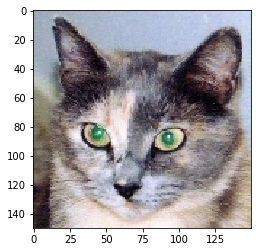

In [13]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In order to extract the feature maps you want to look at, you’ll create a Keras model
that takes batches of images as input, and outputs the activations of all convolution and
pooling layers. To do this, you’ll use the Keras class Model . A model is instantiated
using two arguments: an input tensor (or list of input tensors) and an output tensor
(or list of output tensors). The resulting class is a Keras model, just like the Sequential
models you’re familiar with, mapping the specified inputs to the specified outputs.
What sets the Model class apart is that it allows for models with multiple outputs, unlike
Sequential .

In [14]:
from tensorflow.keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

When fed an image input, this model returns the values of the layer activations in the
original model.

In [15]:
activations = activation_model.predict(img_tensor)

In [16]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


It’s a 148 × 148 feature map with 32 channels. Let’s try plotting the fourth channel of
the activation of the first layer of the original model

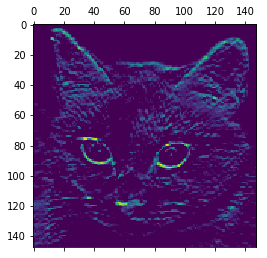

In [17]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

This channel appears to encode a diagonal edge detector. Let’s try the seventh chan-
nel (see figure 5.26)—but note that your own channels may vary, because the specific
filters learned by convolution layers aren’t deterministic.

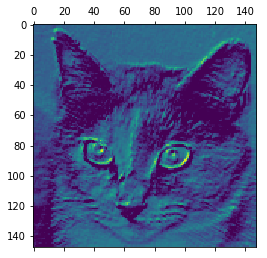

In [19]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

/home/intel/.local/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in divide


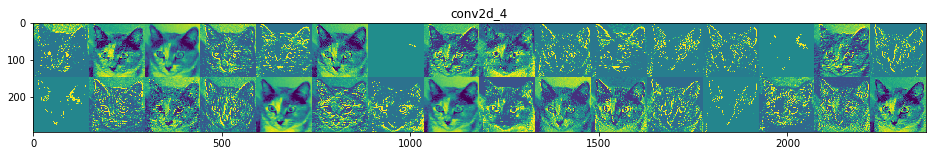

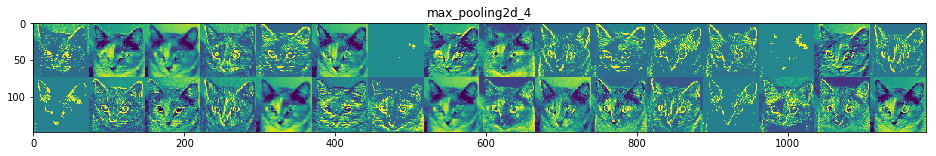

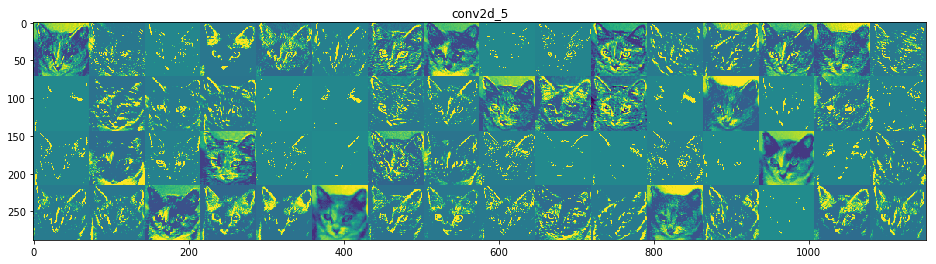

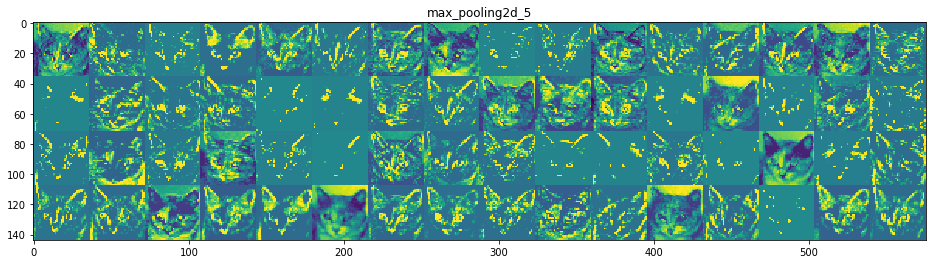

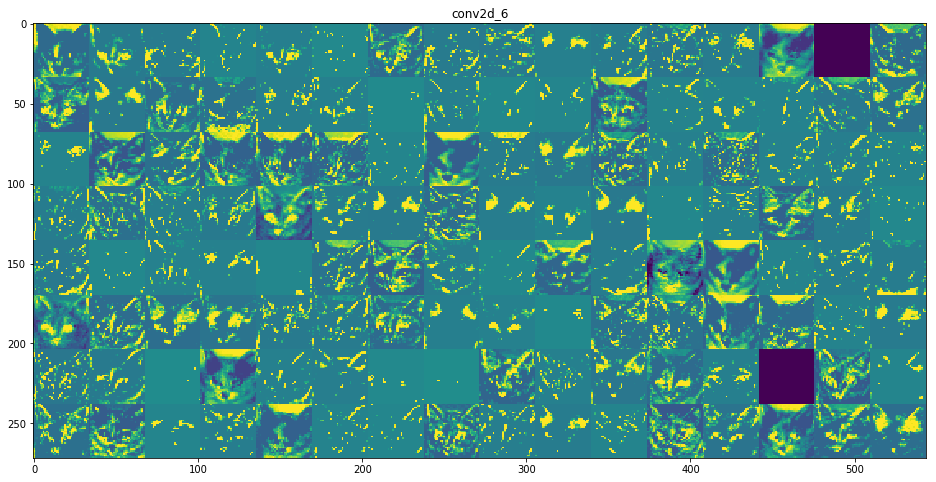

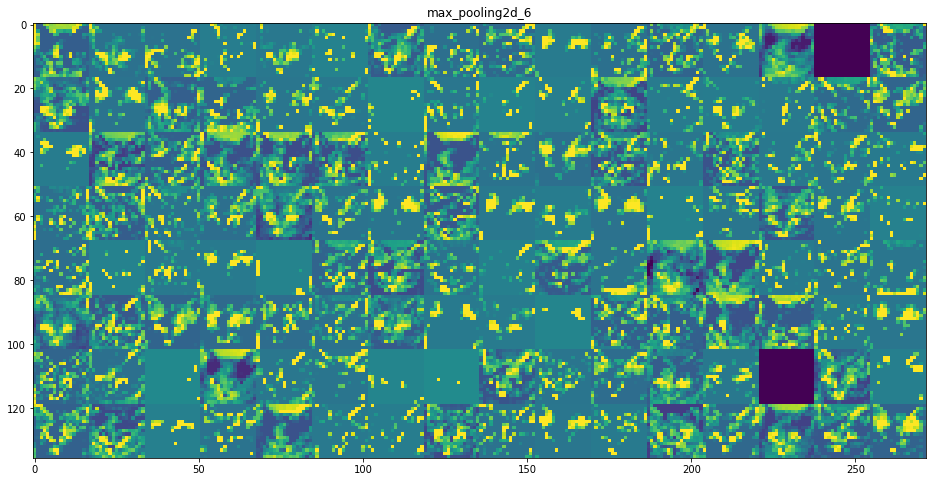

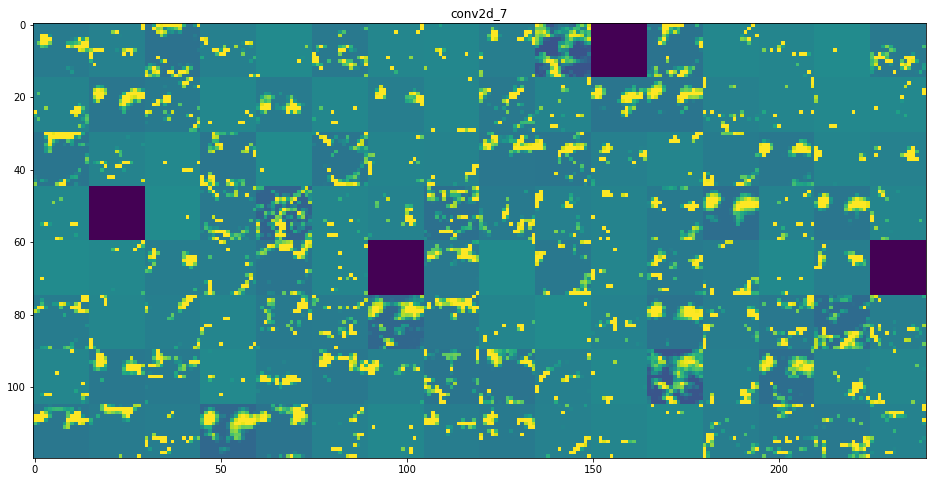

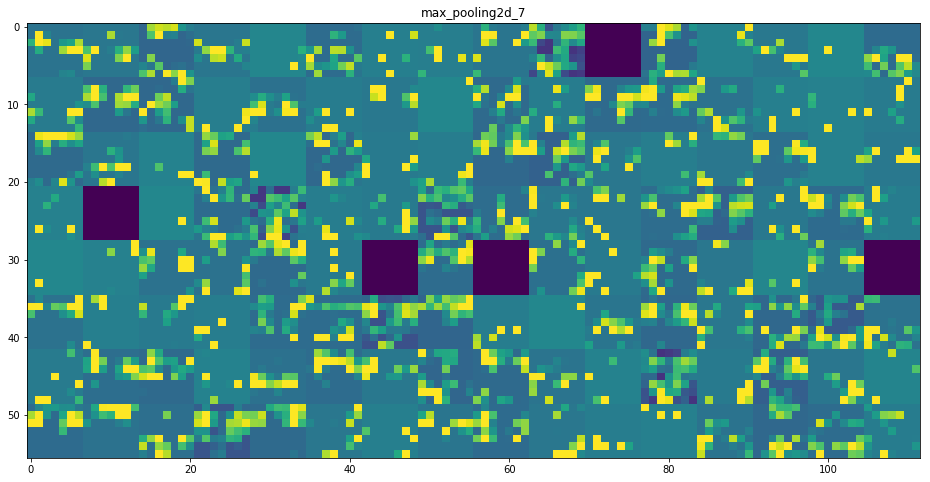

In [20]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                    :, :,
                    col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                    row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Points to Note:


1. the first layer acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information present in the initial picture.
2. As you go higher, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts such as “cat ear” and “cat eye.” Higher presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.
3. The sparsity of the activations increases with the depth of the layer: in the first layer, all filters are activated by the input image; but in the following layers, more and more filters are blank. This means the pattern encoded by the filter isn’t found in the input image.

We have just evidenced an important universal characteristic of the representations
learned by deep neural networks: the features extracted by a layer become increas-
ingly abstract with the depth of the layer. The activations of higher layers carry less
and less information about the specific input being seen, and more and more infor-
mation about the target (in this case, the class of the image: cat or dog). A deep neu-
ral network effectively acts as an information distillation pipeline, with raw data going in
(in this case, RGB pictures) and being repeatedly transformed so that irrelevant infor-
mation is filtered out (for example, the specific visual appearance of the image), and
useful information is magnified and refined (for example, the class of the image).

This is analogous to the way humans and animals perceive the world: after observ-
ing a scene for a few seconds, a human can remember which abstract objects were
present in it (bicycle, tree) but can’t remember the specific appearance of these
objects. In fact, if you tried to draw a generic bicycle from memory, chances are you
couldn’t get it even remotely right, even though you’ve seen thousands of bicycles in
your lifetime (see, for example, figure 5.28). Try it right now: this effect is absolutely
real. You brain has learned to completely abstract its visual input—to transform it into
high-level visual concepts while filtering out irrelevant visual details—making it tre-
mendously difficult to remember how things around you look.